# Examen de cinturón AML – Opción A

## Descripción del examen:

En este examen, trabajarás con un dataset reciente de complejidad baja, donde primero realizarás un análisis no supervisado utilizando K-means o PCA, y luego modelarás el conjunto de datos utilizando un Perceptrón Multicapa (MLP). El objetivo es aplicar técnicas de clustering o reducción de dimensionalidad para analizar los datos, seguido de la implementación de un modelo MLP para realizar predicciones.

## Dataset:
El dataset utilizado para este examen es el «Customer Personality Analysis» disponible en Kaggle. Este conjunto de datos contiene información demográfica y de comportamiento de clientes, con el objetivo de agruparlos y predecir sus patrones de compra.
Enlace al dataset: https://www.kaggle.com/imakash3011/customer-personality-analysis 

## Instrucciones:

### 1. Exploración y preprocesamiento de datos:

* Carga y explora el dataset para identificar las variables más relevantes. Las características incluyen información demográfica como la edad, el ingreso, el estado civil, y datos de comportamiento de compra, como la cantidad gastada en diferentes productos.
* Asegúrate de manejar los valores nulos y realizar un preprocesamiento adecuado, como la normalización de los datos para el análisis posterior.

### 2. Análisis no supervisado:

* Selecciona un enfoque de análisis no supervisado: K-means o PCA.
    * K-means: Si seleccionas K-means, determina el número óptimo de clusters utilizando el método del codo o el silhouette score. Agrupa a los clientes en diferentes clusters y analiza cómo se dividen según sus características demográficas y de compra.
    * PCA: Si eliges PCA, realiza una reducción de dimensionalidad para capturar al menos el 90% de la varianza explicada. Proyecta los datos en los primeros componentes principales y visualiza cómo se agrupan los clientes en el nuevo espacio de características.

### 3. Modelado con MLP:

* Implementa un Perceptrón Multicapa (MLP) para predecir las compras futuras de los clientes o su probabilidad de realizar una compra en una categoría específica de productos.
* Divide el dataset en conjuntos de entrenamiento y prueba, asegurándote de tener una proporción adecuada de cada clase en el conjunto de datos.
* Discute la arquitectura de tu MLP, incluyendo el número de capas ocultas, el número de neuronas en cada capa, y las funciones de activación utilizadas.

### 4. Evaluación del modelo:

* Evalúa el modelo MLP utilizando métricas de clasificación como la precisión, el recall, el F1-score y la matriz de confusión. Asegúrate de comparar estas métricas entre el conjunto de entrenamiento y el conjunto de prueba para identificar cualquier posible sobreajuste.
* Visualiza las curvas de aprendizaje que muestren la pérdida y la precisión a lo largo del entrenamiento.

### 5. Discusión y análisis:

* Reflexiona sobre los resultados del análisis no supervisado y el modelo MLP. ¿Qué insights obtuviste de los clusters o los componentes principales? ¿Cómo se relacionan con el comportamiento de los clientes?
* Discute el rendimiento del modelo MLP. ¿Es adecuado para este tipo de datos? ¿Cómo podrías mejorarlo?

### 6. Entrega final:

* Entrega un informe detallado que incluya todas las etapas del examen: preprocesamiento de datos, análisis no supervisado, modelado MLP, evaluación del modelo y conclusiones. Asegúrate de que el informe sea claro y estructurado, con visualizaciones que apoyen tu análisis.


# Resolución

## 1. Exploración y preprocesamiento de datos:

### Carga y explora el dataset para identificar las variables más relevantes. Las características incluyen información demográfica como la edad, el ingreso, el estado civil, y datos de comportamiento de compra, como la cantidad gastada en diferentes productos.

Notar que esta técnica de carga requiere generar el archivo kaggle.json que posee las claves de acceso a kaggle y agregarlo en el root del repositorio. Se optó por esta técnica, ya que el dataset era relativamente grande y no era lo mas óptimo subirlo al github.

In [1]:
from utils.git_utils import get_repo_file_path
from utils.kaggle_utils import descargar_dataset_kaggle


# Asegúrarse de que el archivo kaggle.json con las credenciales de kaggle
# estén en el directorio base del repositorio.
kaggle_credentials_path = get_repo_file_path("kaggle.json")

descargar_dataset_kaggle(
    "https://www.kaggle.com/imakash3011/customer-personality-analysis",
    kaggle_credentials_path,
    "../data/",
)

Skipping, found downloaded files in "../data/customer-personality-analysis" (use force=True to force download)


In [2]:
import pandas as pd


camino_ds = "../data/customer-personality-analysis/marketing_campaign.csv"
df = pd.read_csv(camino_ds, delimiter="\t")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Notamos que en este dataset existen en total 2240 filas y 28 características, siendo Response la variable objetivo. Se encuentra también una variable potencialmente de tipo fecha, que debe ser analizada.

#### Conversión de columnas booleanas.

In [3]:
columnas = df.columns.tolist()

columnas_convertidas_booleanas = []

valores_columnas_booleanas_potenciales = [
    [0, 1],
    [0.0, 1.0],
    ["false", "true"],
    ["no", "yes"],
    ["no", "si"],
    ["N", "Y"],
]


def _convertir_valor_a_booleano(x):
    if x in [0, 0.0, "false", "no", "no", "N"]:
        return False

    if x in [1, 1.0, "true", "yes", "si", "Y"]:
        return True

    return x


for columna in columnas:
    valores_unicos = df[columna].dropna().unique()

    columna_booleana_encontrada = False

    if len(valores_unicos) == 2:
        print(f"Valores de columna '{columna}': {str(valores_unicos)}")

        for posibilidad_valores_booleanos in valores_columnas_booleanas_potenciales:
            if set(valores_unicos) == set(posibilidad_valores_booleanos):
                print(f"La columna '{columna}' es booleana. Será convertida.")
                df[columna] = df[columna].apply(_convertir_valor_a_booleano)
                df[columna] = df[columna].astype("bool")

                columna_booleana_encontrada = True
                break

    if columna_booleana_encontrada:
        columnas_convertidas_booleanas.append(columna)


print(f"Columnas convertidas a booleanas: {str(columnas_convertidas_booleanas)}")

Valores de columna 'AcceptedCmp3': [0 1]
La columna 'AcceptedCmp3' es booleana. Será convertida.
Valores de columna 'AcceptedCmp4': [0 1]
La columna 'AcceptedCmp4' es booleana. Será convertida.
Valores de columna 'AcceptedCmp5': [0 1]
La columna 'AcceptedCmp5' es booleana. Será convertida.
Valores de columna 'AcceptedCmp1': [0 1]
La columna 'AcceptedCmp1' es booleana. Será convertida.
Valores de columna 'AcceptedCmp2': [0 1]
La columna 'AcceptedCmp2' es booleana. Será convertida.
Valores de columna 'Complain': [0 1]
La columna 'Complain' es booleana. Será convertida.
Valores de columna 'Response': [1 0]
La columna 'Response' es booleana. Será convertida.
Columnas convertidas a booleanas: ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']


Se detectaron varias columnas booleanas en el dataset, que poseen valores 0 y 1. Estas columnas fueron convertidas. Notar además, que la técnica permite ajustar el código en caso de que se detecten nuevos tipos de valores booleanos.

#### Conversión de columnas de tipo fecha.

In [4]:
df['Dt_Customer']

0       04-09-2012
1       08-03-2014
2       21-08-2013
3       10-02-2014
4       19-01-2014
           ...    
2235    13-06-2013
2236    10-06-2014
2237    25-01-2014
2238    24-01-2014
2239    15-10-2012
Name: Dt_Customer, Length: 2240, dtype: object

Efectivamente, esta columna es una fecha. Procedemos a convertirla a su tipo correcto.

In [5]:
from datetime import datetime

def _convertir_fecha(x):
    if pd.isna(x) or pd.isnull(x):
        return x
    try:
        return datetime.strptime(x, "%d-%m-%Y")
    except Exception:
        print(f"Fallo para valor: {x}")
        return x

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"].apply(_convertir_fecha), utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   2240 non-null   int64              
 1   Year_Birth           2240 non-null   int64              
 2   Education            2240 non-null   object             
 3   Marital_Status       2240 non-null   object             
 4   Income               2216 non-null   float64            
 5   Kidhome              2240 non-null   int64              
 6   Teenhome             2240 non-null   int64              
 7   Dt_Customer          2240 non-null   datetime64[ns, UTC]
 8   Recency              2240 non-null   int64              
 9   MntWines             2240 non-null   int64              
 10  MntFruits            2240 non-null   int64              
 11  MntMeatProducts      2240 non-null   int64              
 12  MntFishProducts     

La columna fecha fue convertida correctamente.

#### Conversión de columnas categóricas.

In [6]:
columnas_potencialmente_categoricas = df.select_dtypes(include=["object", "string"]).columns.tolist()

columnas_potencialmente_categoricas

['Education', 'Marital_Status']

In [7]:
from utils.eda_utils import limpiar_cadena


for columna in columnas_potencialmente_categoricas:
    df[columna] = df[columna].apply(limpiar_cadena)

Verificamos y convertimos si es necesario.

In [8]:
# Se elige el 5% como valor para empezar a considerar una columna como categórica.
# Si se supera esta cantidad la columna se dejará como cadena.
porcentaje_max_columnas_categoricas = 0.05
cant_filas_df = df.shape[0]

columnas_a_excluir = []
columnas_convertidas_a_categoricas = []
columnas_convertidas_a_string = []

for columna in columnas_potencialmente_categoricas:
    valores_unicos = df[columna].dropna().unique().tolist()
    print(f"Cant. únicos para columna '{columna}': {len(valores_unicos)}")
    if len(valores_unicos) <= (porcentaje_max_columnas_categoricas * cant_filas_df):
        
        print(f"Valores únicos columna '{columna}': {str(valores_unicos)}")
        print(f"Se procede a convertir la columna '{columna}' a categórica")
        df[columna] = df[columna].astype("category")
        columnas_convertidas_a_categoricas.append(columna)
    else:
        print(f"No se convierte la columna '{columna}' a categórica, se opta por dejarla como string")
        df[columna] = df[columna].astype("string")
        columnas_convertidas_a_string

    del valores_unicos

print("\n")
print(f"Cant. de columnas analizadas: {len(columnas_potencialmente_categoricas)}")
print(f"Cant. de columnas convertidas a category: {len(columnas_convertidas_a_categoricas)}")
print(f"Cant. de columnas convertidas a string: {len(columnas_convertidas_a_string)}")
print(f"Columnas convertidas a categóricas: {str(columnas_convertidas_a_categoricas)}")
print(f"Columnas convertidas a string: {str(columnas_convertidas_a_string)}")

Cant. únicos para columna 'Education': 5
Valores únicos columna 'Education': ['graduation', 'phd', 'master', 'basic', '2n cycle']
Se procede a convertir la columna 'Education' a categórica
Cant. únicos para columna 'Marital_Status': 8
Valores únicos columna 'Marital_Status': ['single', 'together', 'married', 'divorced', 'widow', 'alone', 'absurd', 'yolo']
Se procede a convertir la columna 'Marital_Status' a categórica


Cant. de columnas analizadas: 2
Cant. de columnas convertidas a category: 2
Cant. de columnas convertidas a string: 0
Columnas convertidas a categóricas: ['Education', 'Marital_Status']
Columnas convertidas a string: []


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   2240 non-null   int64              
 1   Year_Birth           2240 non-null   int64              
 2   Education            2240 non-null   category           
 3   Marital_Status       2240 non-null   category           
 4   Income               2216 non-null   float64            
 5   Kidhome              2240 non-null   int64              
 6   Teenhome             2240 non-null   int64              
 7   Dt_Customer          2240 non-null   datetime64[ns, UTC]
 8   Recency              2240 non-null   int64              
 9   MntWines             2240 non-null   int64              
 10  MntFruits            2240 non-null   int64              
 11  MntMeatProducts      2240 non-null   int64              
 12  MntFishProducts     

Se encontraron dos columnas categóricas. No se encontró ninguna columna de tipo cadena. Notar además, que el código se puede ajustar de acuerdo a lo que se imprime en caso de que se detecten irregularidades.

#### Verificación de datos de tipo numéricos.

In [10]:
columnas_numericas = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
columnas_numericas

['ID',
 'Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Z_CostContact',
 'Z_Revenue']

In [11]:
porcentaje_max_columnas_categoricas = 0.05
cant_filas_df = df.shape[0]

for columna in columnas_numericas:
    valores_unicos = df[columna].dropna().unique().tolist()
    print(f"Cant. únicos para columna '{columna}': {len(valores_unicos)}")
    if len(valores_unicos) <= (porcentaje_max_columnas_categoricas * cant_filas_df):
        print(f"Valores únicos columna '{columna}': {str(valores_unicos)}")
    del valores_unicos


Cant. únicos para columna 'ID': 2240
Cant. únicos para columna 'Year_Birth': 59
Valores únicos columna 'Year_Birth': [1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 1974, 1950, 1983, 1976, 1959, 1952, 1987, 1946, 1980, 1949, 1982, 1979, 1951, 1969, 1986, 1989, 1963, 1970, 1973, 1943, 1975, 1996, 1968, 1964, 1977, 1978, 1955, 1966, 1988, 1948, 1958, 1972, 1960, 1945, 1991, 1962, 1953, 1961, 1956, 1992, 1900, 1893, 1990, 1947, 1899, 1993, 1994, 1941, 1944, 1995, 1940]
Cant. únicos para columna 'Income': 1974
Cant. únicos para columna 'Kidhome': 3
Valores únicos columna 'Kidhome': [0, 1, 2]
Cant. únicos para columna 'Teenhome': 3
Valores únicos columna 'Teenhome': [0, 1, 2]
Cant. únicos para columna 'Recency': 100
Valores únicos columna 'Recency': [58, 38, 26, 94, 16, 34, 32, 19, 68, 11, 59, 82, 53, 23, 51, 20, 91, 86, 41, 42, 63, 0, 69, 89, 4, 96, 56, 31, 8, 55, 37, 76, 99, 3, 88, 80, 72, 24, 92, 39, 29, 2, 54, 57, 30, 12, 18, 75, 90, 1, 25, 40, 9, 87, 5, 95, 48, 70, 79, 45, 84, 44, 43,

No se puede identificar ninguna columna numérica potencialmente categórica. Sí se puede notar que existen dos variables para denotar la cantidad de hijos, kidhome, y teenhome. Estas características podrían potencialmente ser unificadas en una sola variable. En caso de implementarse, se hará en la sección de creación de modelos.

#### Verificación de datos nulos.

In [12]:
from utils.eda_utils import obtener_estadisticas_datos_nulos


estadisticas_datos_nulos = obtener_estadisticas_datos_nulos(df)
estadisticas_datos_nulos

,datos sin NAs en q,Na en q,Na en %
Income,2216,24,1.07
ID,2240,0,0.00
NumDealsPurchases,2240,0,0.00
Z_Revenue,2240,0,0.00
Z_CostContact,2240,0,0.00
Complain,2240,0,0.00
AcceptedCmp2,2240,0,0.00
AcceptedCmp1,2240,0,0.00
AcceptedCmp5,2240,0,0.00
AcceptedCmp4,2240,0,0.00


Podemos notar que existe solo una columna con datos nulos, Income.

In [13]:
from utils.eda_utils import obtener_estadisticas_descriptivas_df_es


obtener_estadisticas_descriptivas_df_es(df[["Income"]]).T

,Cantidad,Mínimo,Máximo,Promedio,Desviación Estándar,Mediana,Coeficiente de Variación
Income,2216.0,1730.0,666666.0,52247.251354,25173.076661,51381.5,0.481807


De las estadísticas descriptivas para esta columna, podemos notar que el coeficiente de variación es del 48%, superior al 30%, por lo cual, el promedio en esta columna no es representativo, y debe imputarce con otras técnicas.


Se opta por utilizar un RandomForestRegressor como técnica de predicción para imputación de estos valores. Notar que en esta sección solamente se evalúa el performance de la imputación, con el objetivo de determinar qué tan bueno es el predictor, y en la sección del modelado se entrenará este imputador de vuelta con los datos de train y test, evitando así que datos de test afecten el entrenamiento del modelo. Para la predicción de income, se eligen para la predicción solamente columnas que nos pueden indicar el nivel de ingresos de la persona:

Columnas de Gastos:
* MntWines
* MntMeatProducts
* MntFishProducts
* MntSweetProducts
* MntGoldProducts

Datos personales
* Education
* Year_Birth

Datos de Ofertas:
* NumDealsPurchases: Este parámetro nos indica potencialmente si el cliente es más propenso a tomar descuentos, por lo que también se usa en la predicción.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


preprocessor_imputer = ColumnTransformer(transformers=[
    ("ordinal", OrdinalEncoder(categories=[['basic', '2n cycle', 'graduation', 'master', 'phd']]), ["Education",]),
], remainder="passthrough")

imputer = Pipeline(steps=[
    ("preprocessor", preprocessor_imputer),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42)),
])

df_income_no_na = df[df["Income"].notna()]

X_imputer = df_income_no_na[[
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts", 
    "MntSweetProducts", 
    "MntGoldProds",
    "Education",
    "Year_Birth",
    "NumDealsPurchases",
]]
y_imputer = df_income_no_na["Income"]

X_imputer_train, X_imputer_test, y_imputer_train, y_imputer_test = train_test_split(
    X_imputer,
    y_imputer,
    test_size=0.3,
    random_state=42,
)

In [15]:
imputer.fit(X_imputer_train, y_imputer_train)

/home/diego/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['basic',
                                                                              '2n '
                                                                              'cycle',
                                                                              'graduation',
                                                                              'master',
                                                                              'phd']]),
                                                  ['Education'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [16]:
# Realizar predicciones
y_imputer_pred = imputer.predict(X_imputer_test)

# Evaluar el modelo
rmse = root_mean_squared_error(y_imputer_test, y_imputer_pred)
mse = rmse ** 2
r2 = r2_score(y_imputer_test, y_imputer_pred)
mae = mean_absolute_error(y_imputer_test, y_imputer_pred)

print(f'Raíz Error Cuadrático Medio (RMSE): {rmse}')
print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'R-cuadrado (R2): {r2}')
print(f'Error Absoluto Medio (MAE): {mae}')

Raíz Error Cuadrático Medio (RMSE): 11668.994171437202
Error Cuadrático Medio (MSE): 136165424.9730354
R-cuadrado (R2): 0.7002549867300025
Error Absoluto Medio (MAE): 6997.664263157893


De los resultados obtenidos, no parece ser que se obtenga un performance muy alto en el modelo predictivo seleccionado. Esto nos indica que la estrategia de imputación por predicción no está teniendo tan buen performance.

De igual manera, se opta por mantener este modelo, pero sólamente para predicciones en datos futuros. No se utilizará en la fase de entrenamiento, ya que la cantidad de nulos en income es muy bajo, y eliminarlos no afectaría los resultados del entrenamiento.

Solo a modo de verificación, comprobamos que la imputación en Income no introduzca sesgos en la columna.

In [17]:
df_imputed = df.copy()

In [18]:
X_income_nan = df_imputed.loc[df_imputed["Income"].isna(),:][[
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts", 
    "MntSweetProducts", 
    "MntGoldProds",
    "Education",
    "Year_Birth",
    "NumDealsPurchases",
]]

df_imputed.loc[df_imputed["Income"].isna(), "Income"] = imputer.predict(X_income_nan)

In [19]:
obtener_estadisticas_datos_nulos(df_imputed)

,datos sin NAs en q,Na en q,Na en %
ID,2240,0,0.0
NumDealsPurchases,2240,0,0.0
Z_Revenue,2240,0,0.0
Z_CostContact,2240,0,0.0
Complain,2240,0,0.0
AcceptedCmp2,2240,0,0.0
AcceptedCmp1,2240,0,0.0
AcceptedCmp5,2240,0,0.0
AcceptedCmp4,2240,0,0.0
AcceptedCmp3,2240,0,0.0


/tmp/ipykernel_101749/1319036204.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Income'], label='Original', shade=True)
/tmp/ipykernel_101749/1319036204.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_imputed['Income'], label='Imputado', shade=True)


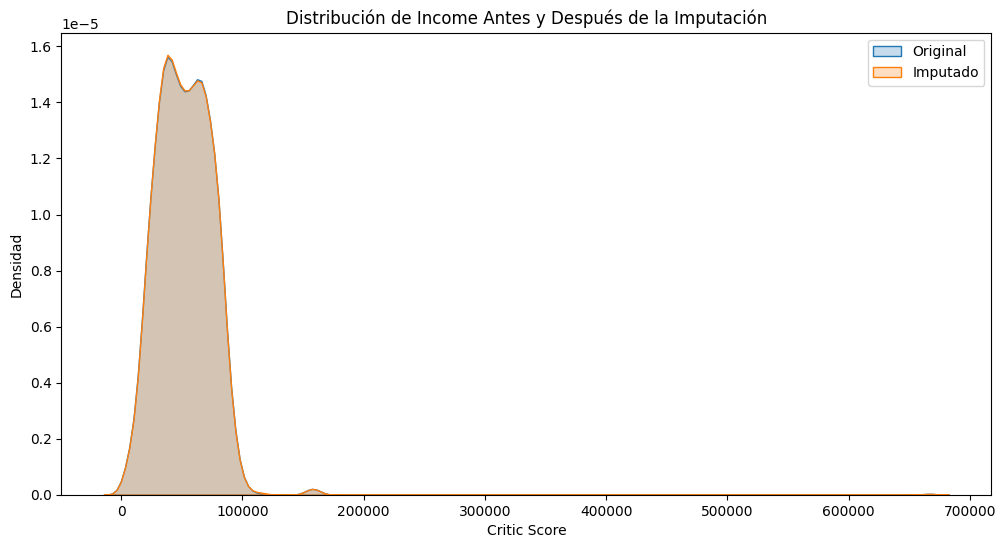

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(df['Income'], label='Original', shade=True)
sns.kdeplot(df_imputed['Income'], label='Imputado', shade=True)
plt.title('Distribución de Income Antes y Después de la Imputación')
plt.xlabel('Critic Score')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Podemos notar que no existen sesgos representativos al imputar Income con el modelo predictivo. De igual manera, se opta por no usar estas imputaciones para las predicciones, y solo se mantiene el modelo entrenado para usarlo al encontrar datos nulos en la columna Income en producción.

Procedemos a eliminar las filas que contienen datos nulos en Income para el entrenamiento.

In [21]:
df.dropna(subset=["Income",], inplace=True)

In [22]:
obtener_estadisticas_datos_nulos(df)

,datos sin NAs en q,Na en q,Na en %
ID,2216,0,0.0
NumDealsPurchases,2216,0,0.0
Z_Revenue,2216,0,0.0
Z_CostContact,2216,0,0.0
Complain,2216,0,0.0
AcceptedCmp2,2216,0,0.0
AcceptedCmp1,2216,0,0.0
AcceptedCmp5,2216,0,0.0
AcceptedCmp4,2216,0,0.0
AcceptedCmp3,2216,0,0.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   2216 non-null   int64              
 1   Year_Birth           2216 non-null   int64              
 2   Education            2216 non-null   category           
 3   Marital_Status       2216 non-null   category           
 4   Income               2216 non-null   float64            
 5   Kidhome              2216 non-null   int64              
 6   Teenhome             2216 non-null   int64              
 7   Dt_Customer          2216 non-null   datetime64[ns, UTC]
 8   Recency              2216 non-null   int64              
 9   MntWines             2216 non-null   int64              
 10  MntFruits            2216 non-null   int64              
 11  MntMeatProducts      2216 non-null   int64              
 12  MntFishProducts      2216

In [24]:
df[df["Income"] == 0]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


#### Estadísticas descriptivas.

In [25]:
obtener_estadisticas_descriptivas_df_es(df).T

,Cantidad,Mínimo,Máximo,Promedio,Desviación Estándar,Mediana,Coeficiente de Variación
ID,2216.0,0.0,11191.0,5588.353339,3249.376275,5458.5,0.581455
Year_Birth,2216.0,1893.0,1996.0,1968.820397,11.985554,1970.0,0.006088
Income,2216.0,1730.0,666666.0,52247.251354,25173.076661,51381.5,0.481807
Kidhome,2216.0,0.0,2.0,0.441787,0.536896,0.0,1.215283
Teenhome,2216.0,0.0,2.0,0.505415,0.544181,0.0,1.076701
Recency,2216.0,0.0,99.0,49.012635,28.948352,49.0,0.590630
MntWines,2216.0,0.0,1493.0,305.091606,337.327920,174.5,1.105661
MntFruits,2216.0,0.0,199.0,26.356047,39.793917,8.0,1.509859
MntMeatProducts,2216.0,0.0,1725.0,166.995939,224.283273,68.0,1.343046
MntFishProducts,2216.0,0.0,259.0,37.637635,54.752082,12.0,1.454716


In [26]:
df["ID"].unique().shape

(2216,)

De las estadísticas descriptivas numéricas podemos determinar:

* La columna ID es un identificador de cliente único, que no necesariamente es un valor realmente importante al momento de realizar predicciones.
* Year_Birth incluye un mínimo de 1893. Es improbable se haga seguimiento de estos clientes hace más de un siglo, por lo que se interpretan estos datos como errores.
* La columna income tiene un máximo 666.666 que potencialmente es un valor incorrecto. Se verificará con gráfico de boxplots para determinar si es un outlier incorrecto o no.
* Las columnas Kidhome y teenhome no parecen tener datos inusuales, siendo el máximo para ambas columnas 0.
* Recency parece estar en rangos normales, ya que indica la cantidad en días desde la última compra del cliente.
* Las columnas de cantidades de compra y montos de compra no parece tener un rango incorrecto, se verificará luego en el EDA con gráficos de tipo boxplots.
* Tanto Z_CostContact y Z_Revenue poseen una desviación estándar de 0, lo que indica que todos los valores encontrados son los mismos. Esto no nos será util al momento de crear modelos predictivos, por lo que se opta por eliminar estas columnas.

In [27]:
df.drop(columns=["Z_CostContact", "Z_Revenue"], axis=1, inplace=True)

Verificamos el boxplot de income para identificar outliers incorrectos:

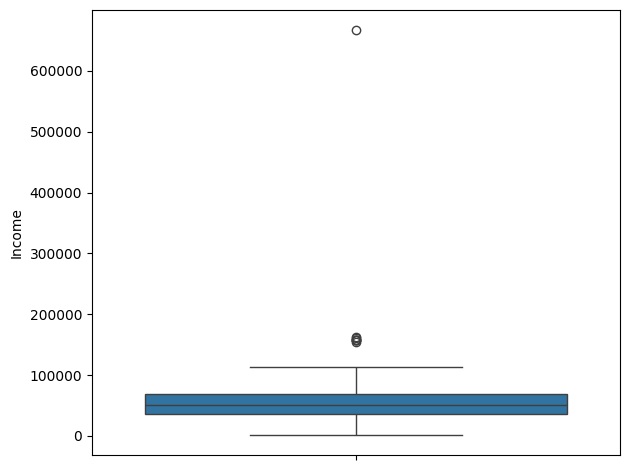

In [28]:
sns.boxplot(df["Income"])
plt.tight_layout()
plt.show()

Del boxplot, podemos notar que efectivamente este outlier 666.666 está muy fuera de rango. Si bien, existe la posibilidad de que una persona tenga ingresos muy altos, este nro es bastante inusual ya que por lo general los clientes al reportar su rango salarial mencionarían un valor redondo en vez de dar el monto exacto, y esto parece mas bien un caso simplemente de error de tipeo. Adicionalmente, al ser un sólo registro, se opta por eliminar este valor, ya que no afectaría al entrenamiento.

In [29]:
df.drop(index=df[df["Income"] > 600_000].index, inplace=True)

Verificamos el boxplot de Year_Birth.

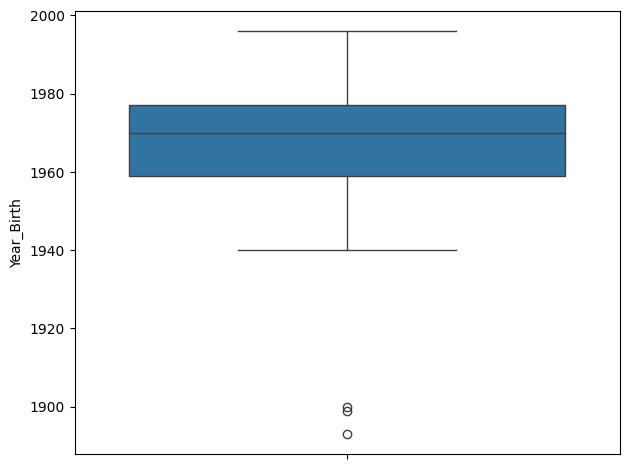

In [30]:
sns.boxplot(df["Year_Birth"])
plt.tight_layout()
plt.show()

Efectivamente, es poco probable que estos datos sean correctos. También, la cant de registros es baja, por lo que se opta por eliminar estas filas.

In [31]:
df.drop(index=df[df["Year_Birth"] < 1930].index, inplace=True)

In [32]:
obtener_estadisticas_descriptivas_df_es(df).T

,Cantidad,Mínimo,Máximo,Promedio,Desviación Estándar,Mediana,Coeficiente de Variación
ID,2212.0,0.0,11191.0,5585.160940,3247.523735,5454.5,0.581456
Year_Birth,2212.0,1940.0,1996.0,1968.913653,11.701599,1970.0,0.005943
Income,2212.0,1730.0,162397.0,51958.810579,21527.278844,51371.0,0.414314
Kidhome,2212.0,0.0,2.0,0.441682,0.536955,0.0,1.215706
Teenhome,2212.0,0.0,2.0,0.505877,0.544253,0.0,1.075861
Recency,2212.0,0.0,99.0,49.019439,28.943121,49.0,0.590442
MntWines,2212.0,0.0,1493.0,305.287523,337.322940,175.5,1.104935
MntFruits,2212.0,0.0,199.0,26.329566,39.744052,8.0,1.509484
MntMeatProducts,2212.0,0.0,1725.0,167.029837,224.254493,68.0,1.342601
MntFishProducts,2212.0,0.0,259.0,37.648734,54.772033,12.0,1.454817


In [33]:
df.describe(include='category').T

,count,unique,top,freq
Education,2212,5,graduation,1115
Marital_Status,2212,8,married,857


De estos datos podemos notar:

* La columna education tiene una moda de graduation, indicando que la mayoría de los clientes posee al menos un título universitario.
* La columna Marital_Status nos indica que la mayoría de los clientes en este dataset están casados.

#### Análisis de datos outliers.

In [34]:
from utils.eda_utils import obtener_datos_outliers_df


obtener_datos_outliers_df(df).T

,Nro. Outliers,Porc. Outliers,Límite mínimo,Límite máximo,Q1,Q3,IQR,Mínimo valor encontrado,Máximo valor encontrado
ID,0.0,0.000000,-5590.875,16824.125,2814.75,8418.50,5603.75,0.0,11191.0
Year_Birth,0.0,0.000000,1932.000,2004.000,1959.00,1977.00,18.00,1940.0,1996.0
Income,7.0,0.316456,-14646.750,118367.250,35233.50,68487.00,33253.50,1730.0,162397.0
Kidhome,0.0,0.000000,-1.500,2.500,0.00,1.00,1.00,0.0,2.0
Teenhome,0.0,0.000000,-1.500,2.500,0.00,1.00,1.00,0.0,2.0
Recency,0.0,0.000000,-51.000,149.000,24.00,74.00,50.00,0.0,99.0
MntWines,35.0,1.582278,-697.500,1226.500,24.00,505.00,481.00,0.0,1493.0
MntFruits,245.0,11.075949,-44.500,79.500,2.00,33.00,31.00,0.0,199.0
MntMeatProducts,173.0,7.820976,-308.375,556.625,16.00,232.25,216.25,0.0,1725.0
MntFishProducts,222.0,10.036166,-67.500,120.500,3.00,50.00,47.00,0.0,259.0


De los datos outlieres, podemos notar que existe un gran porcentaje de outliers en las sgtes. columnas:

* MntWines
* MntFruits
* MntMeatOridycts
* MntSweetProducts
* MntGoldProducts

Esto nos indica que para el modelado, es importante seleccionar una técnica de escalamiento que considere estos outliers.

#### Verificación de datos duplicados.

Eliminamos la columna ID para identificar duplicados que pudieran afectar el entrenamiento de modelos predictivos. Si bien cada cliente es único en el dataset, el hecho de que existan columnas duplicadas en el dataset puede causar sesgos en el entrenamiento.

In [35]:
df.drop(columns="ID", axis=1, inplace=True)

In [36]:
duplicados = df.duplicated()

cant_registros_duplicados = duplicados.sum()

print(f"Cant. de Registros Duplicados general: {cant_registros_duplicados}")

Cant. de Registros Duplicados general: 182


Se encontraron duplicados, por lo que se procede a eliminar estos datos para evitar sesgos en los modelos predictivos.

In [37]:
df.drop_duplicates(inplace=True)

#### EDA

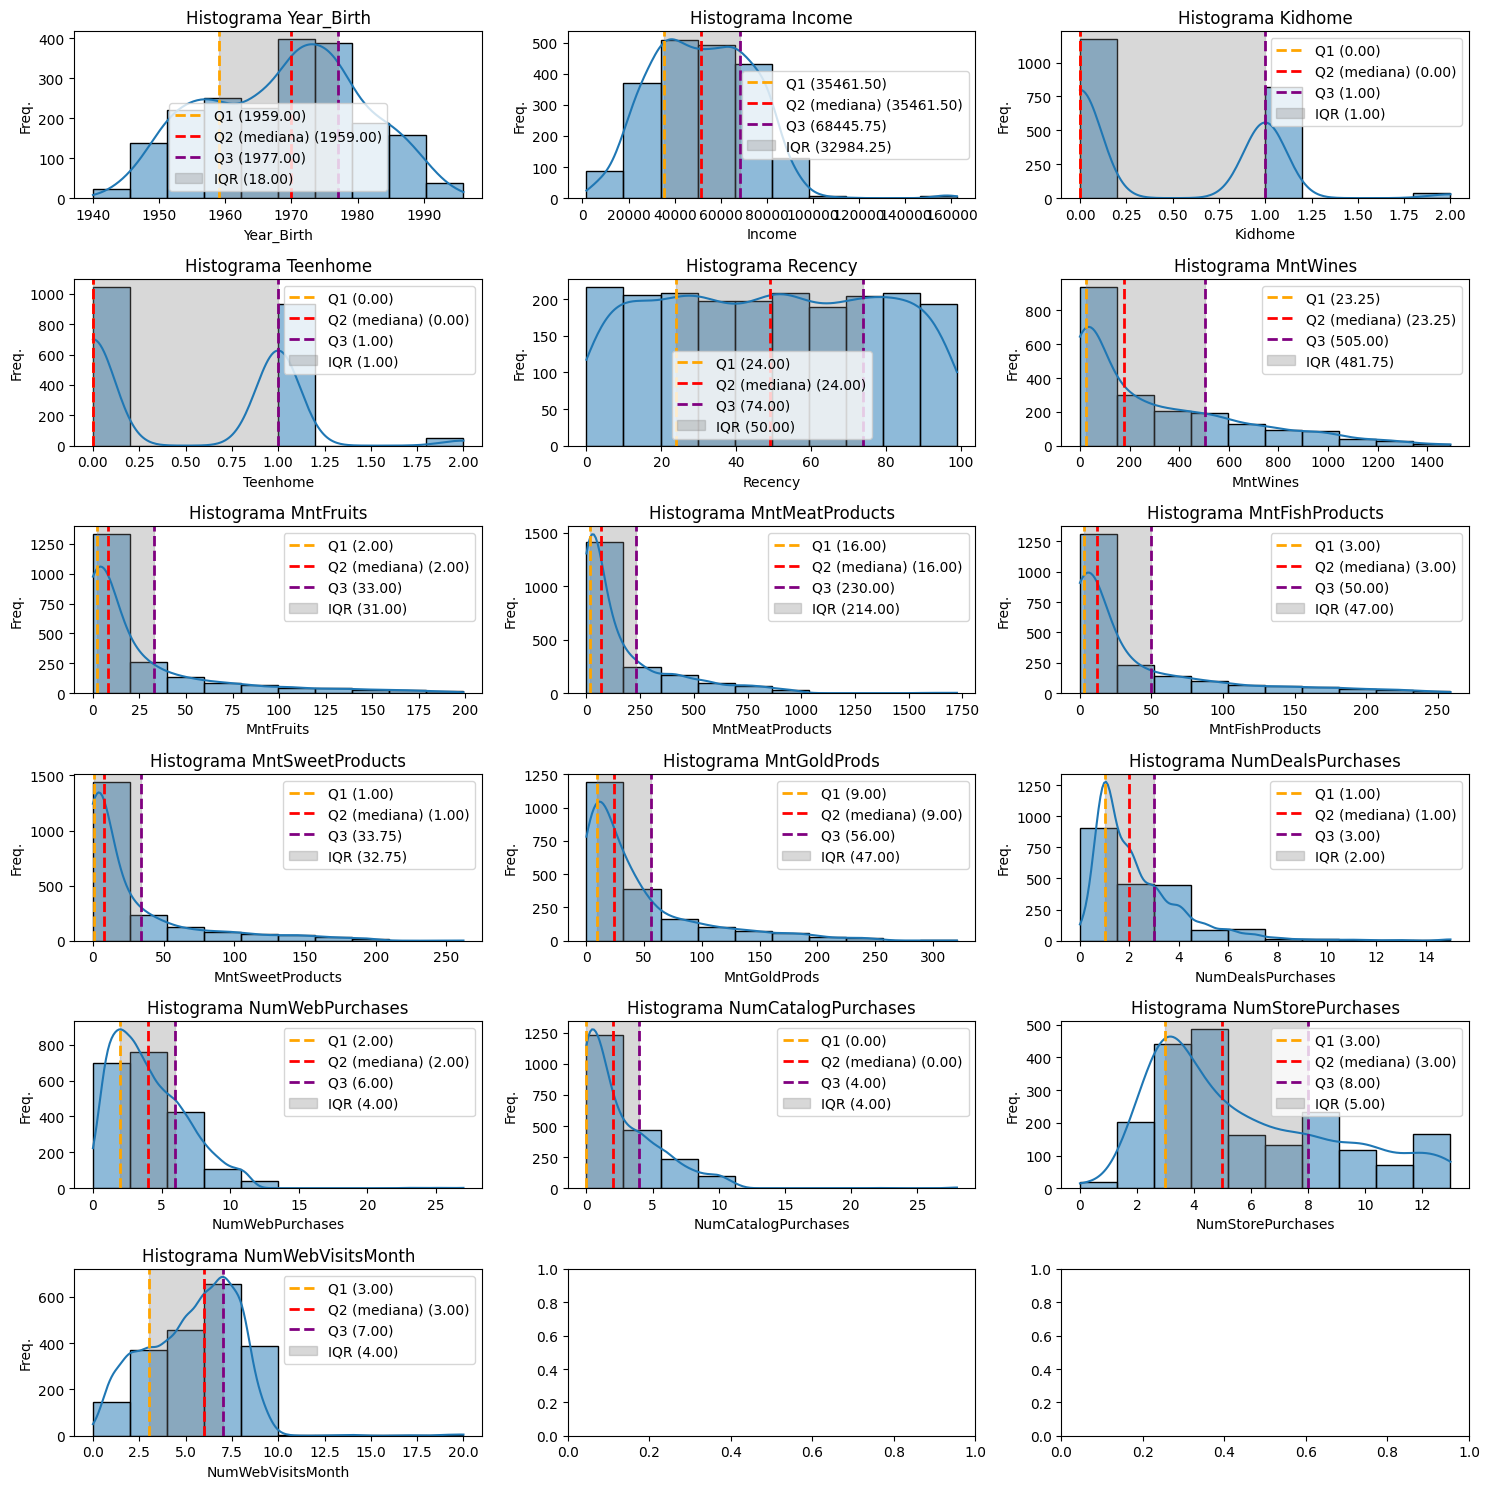

In [38]:
from utils.eda_utils import graficar_histogramas


columnas_numericas = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

graficar_histogramas(df, columnas_numericas, nro_columnas=3, bins=10, kde=True, figsize=(15, 15))

De los histogramas podemos destacar:

* Year_Birth: La mayoría de los clientes en el dataset nacieron entre 1960 y 2000, sugiriendo que tienen como mínimo la edad de 24 años.
* Income: los datos están mas concentrados entre 30.000-40.000.
* Las columnas de hijos poseen distribuciones normales, siendo 2 hijos la menor cantidad en ambos casos.
* Recency parece tener una distribución muy equitativa.
* Las columnas de montos de gasto (MntWines, MntFruits, etc) muestran una distribución muy concentrada en los precios mas económicos, reduciéndose de a poco a medida que incrementa el precio. Estos precios más altos pueden interpretarse como outliers, y se verificarán luego con los boxplots.
* En la columna NumDealsPurchases, podemos notar que la mayoría de los clientes toman hastas 4 ofertas como máximo, siendo mas raro que tomen más.
* En la columna NumWebPurchases, notamos que hay un rango un poco más distribuído hasta approx. 8 compras online.
* En la columna NumCatalogPurchases, notamos que la mayoría de clientes realizan a lo sumo hasta 5 compras del catálogo
* En la columna NumStorePurchases, notamos que las compras están mejor distribuidas en comparación a NumWebPurchases y NumCatalogPurchases, visualizando que la mayoría de clientes compran en el rango de 3 a 5 compras approx.
* La columna NumWebVisitsMonrth indica que la mayoría de clientes visita a lo sumo hasta 10 veces el sitio web, verificándose también potenciales outliers superiores.

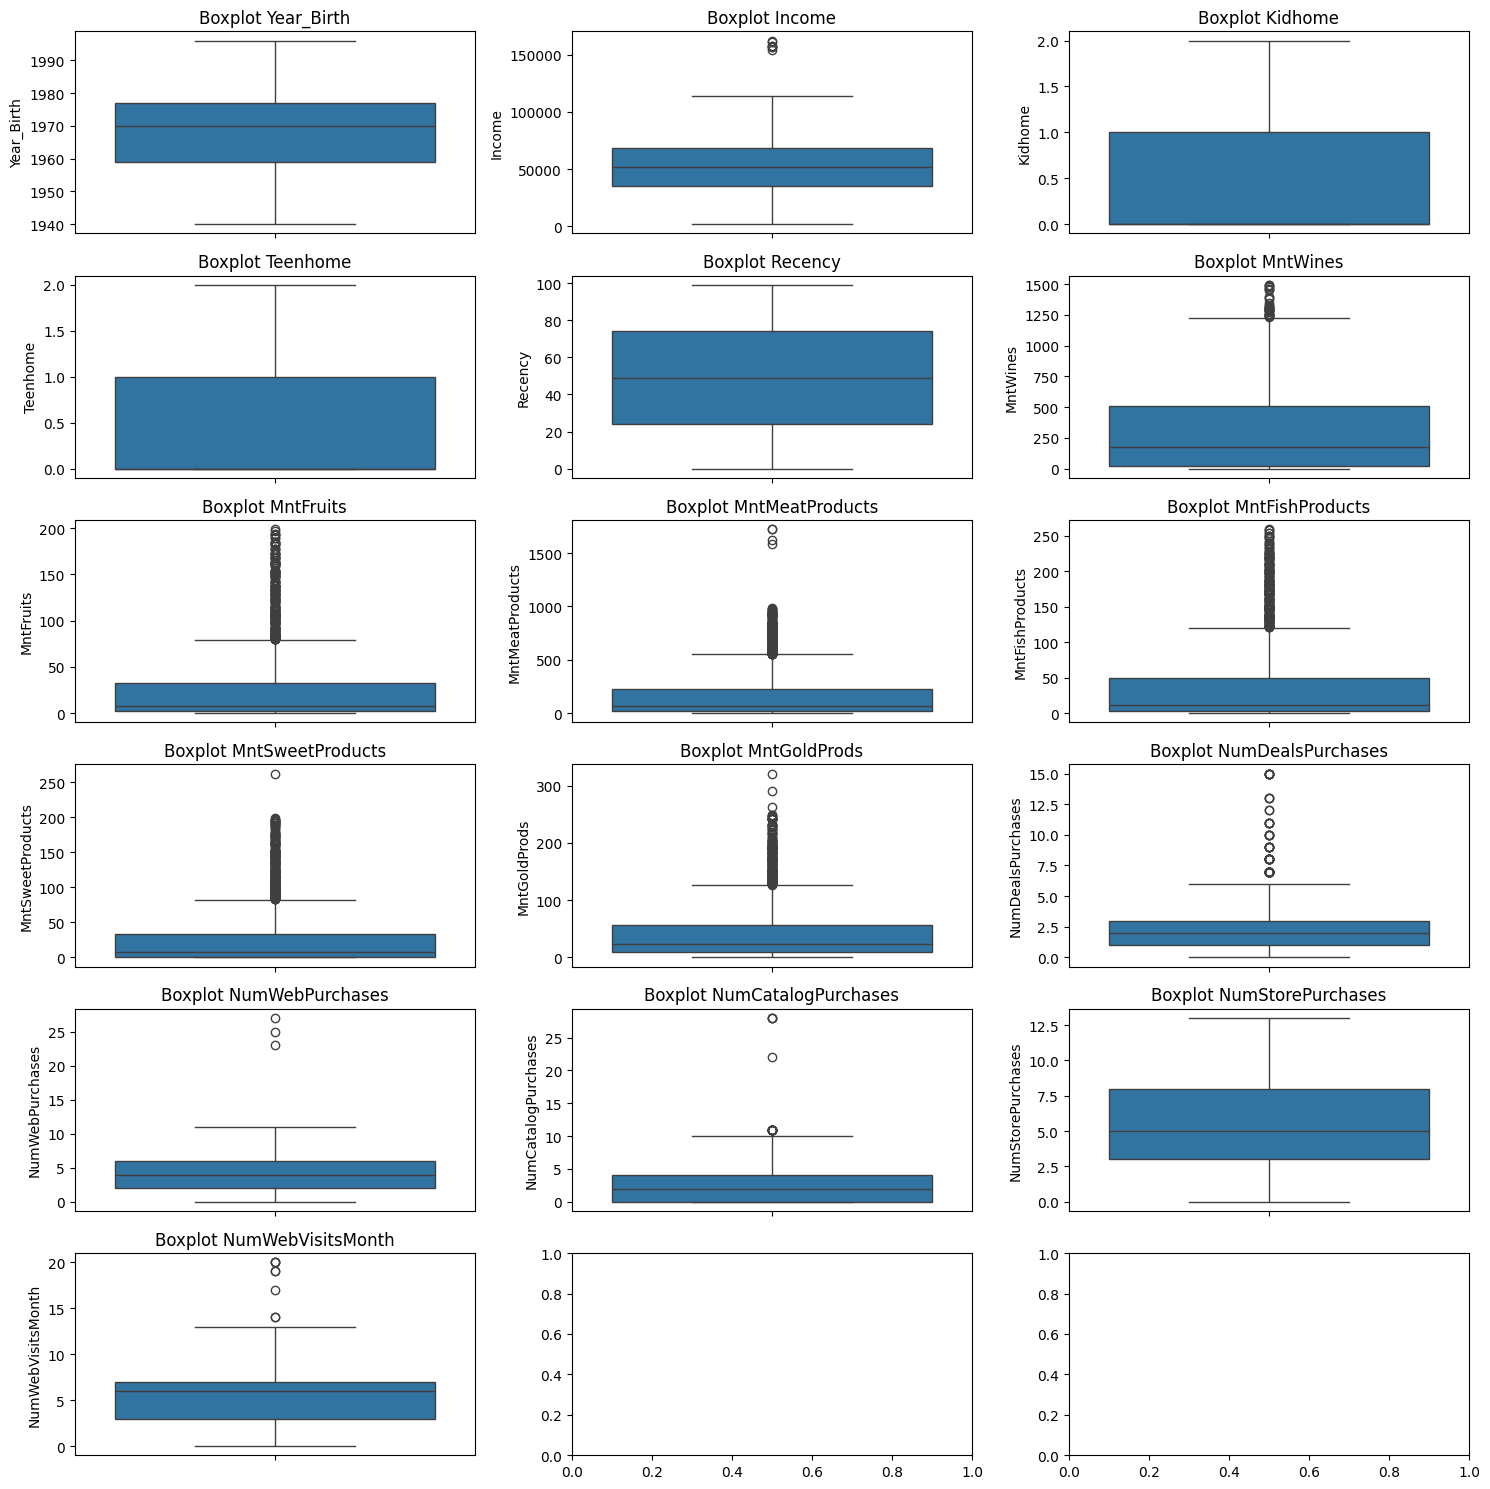

In [39]:
from utils.eda_utils import graficar_boxplots


graficar_boxplots(df, columnas_numericas, nro_columnas=3, figsize=(15, 15))

De los boxplots podemos destacar:

* En las columnas de monto gastado, se visualiza una gran cantidad de outliers.
* También se pueden visualizar outliers, aunque en menor medida, en las columnas NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumWebVisitsMonth.
* Las columnas Kidhome y Teenhome presentan una mediana (Q2) no centrada, indicando que hay una mayor cantidad de clientes con menor cant. de hijos con respecto al máximo de 2.
* También se vizualiza en los datos de montos gastados que la mediana no está centrada

Estas visualizaciones refuerzan la necesida de implementar técnicas de escalamiento robustas ante outliers, como el RobustScaler de Scikit Learn.